In [ ]:
!pip install ultralytics wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [ ]:
!unzip axial_t1wce_2_class.zip

Archive:  axial_t1wce_2_class.zip
   creating: axial_t1wce_2_class/
  inflating: axial_t1wce_2_class/axial_t1wce_2_class.yaml  
   creating: axial_t1wce_2_class/images/
   creating: axial_t1wce_2_class/images/test/
  inflating: axial_t1wce_2_class/images/test/00018_101.jpg  
  inflating: axial_t1wce_2_class/images/test/00018_109.jpg  
  inflating: axial_t1wce_2_class/images/test/00018_111.jpg  
  inflating: axial_t1wce_2_class/images/test/00018_117.jpg  
  inflating: axial_t1wce_2_class/images/test/00018_121.jpg  
  inflating: axial_t1wce_2_class/images/test/00018_126.jpg  
  inflating: axial_t1wce_2_class/images/test/00018_134.jpg  
  inflating: axial_t1wce_2_class/images/test/00019_66.jpg  
  inflating: axial_t1wce_2_class/images/test/00019_75.jpg  
  inflating: axial_t1wce_2_class/images/test/00019_84.jpg  
  inflating: axial_t1wce_2_class/images/test/00019_85.jpg  
  inflating: axial_t1wce_2_class/images/test/00021_53.jpg  
  inflating: axial_t1wce_2_class/images/test/00022_73.jpg 

In [ ]:
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/content/axial_t1wce_2_class/', 'dataset')

'dataset'

In [ ]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00317_21


(512, 512, 3)


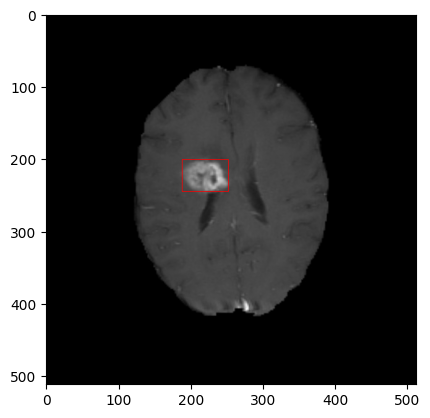

In [ ]:
with open(os.path.join('/content/dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [ ]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [ ]:
train_set = set([i.split('.')[0] for i in train_images])
train_set_label = set([i.split('.')[0] for i in train_labels])

In [ ]:
train_images = [i+'.jpg' for i in train_set.intersection(train_set_label)]
train_labels = [i+'.txt' for i in train_set.intersection(train_set_label)]

In [ ]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))

In [ ]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

os.mkdir('./dataset/images/val')
os.mkdir('./dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

In [ ]:
text = """
path: /content/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

In [ ]:
model = YOLO('yolov8s.pt')

In [ ]:
results = model.train(data='/content/fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/fixed_path.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

train: Scanning /content/dataset/labels/train... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<00:00, 1305.64it/s]

train: New cache created: /content/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1397.51it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/12 [01:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#print(results)

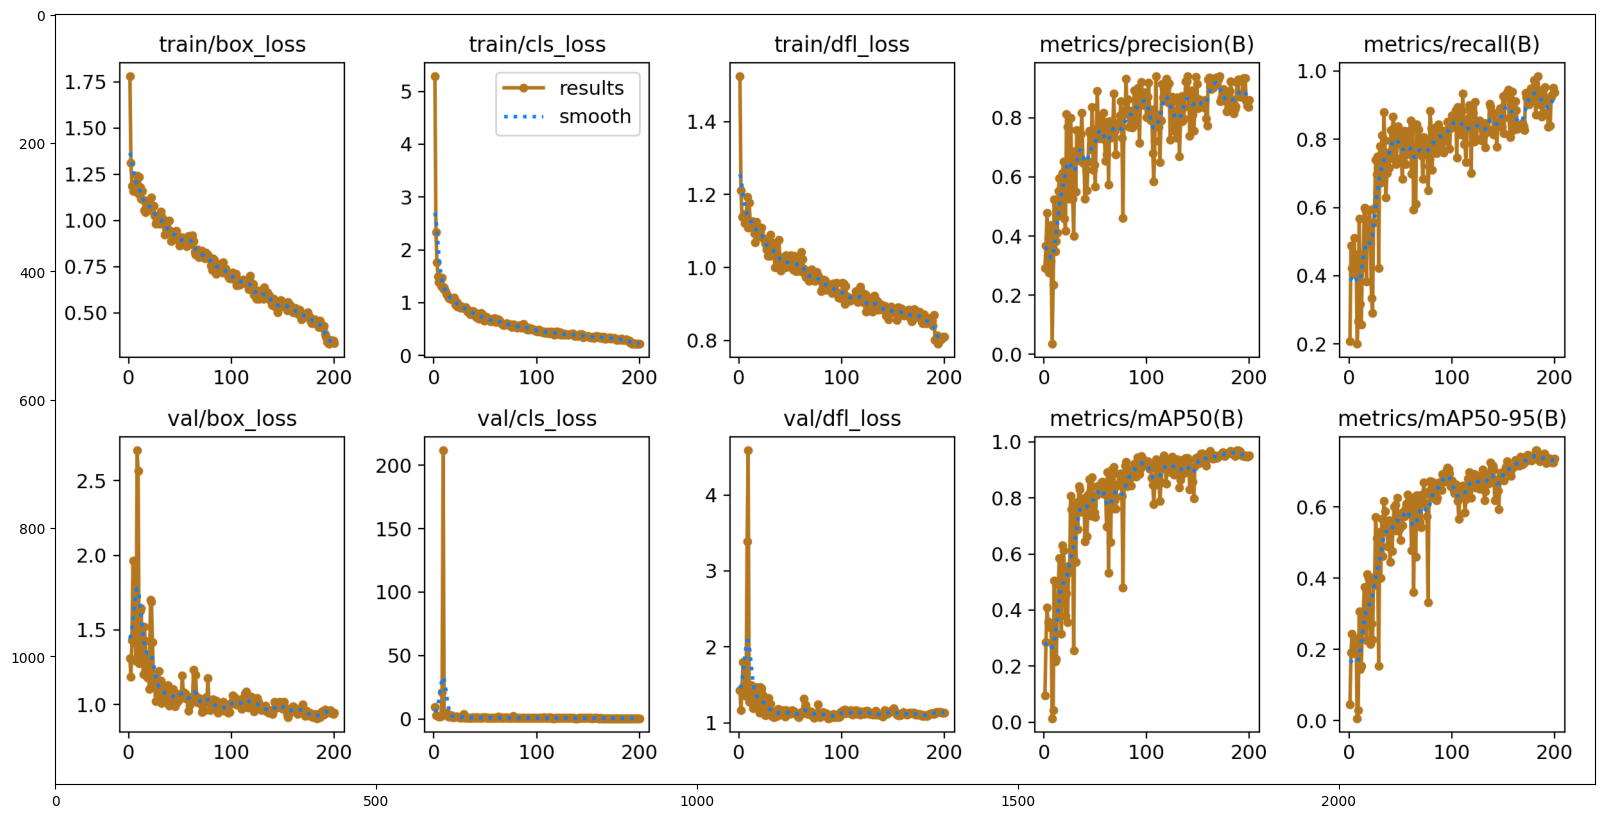

In [ ]:
training_save_dir = '/kaggle/working/' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

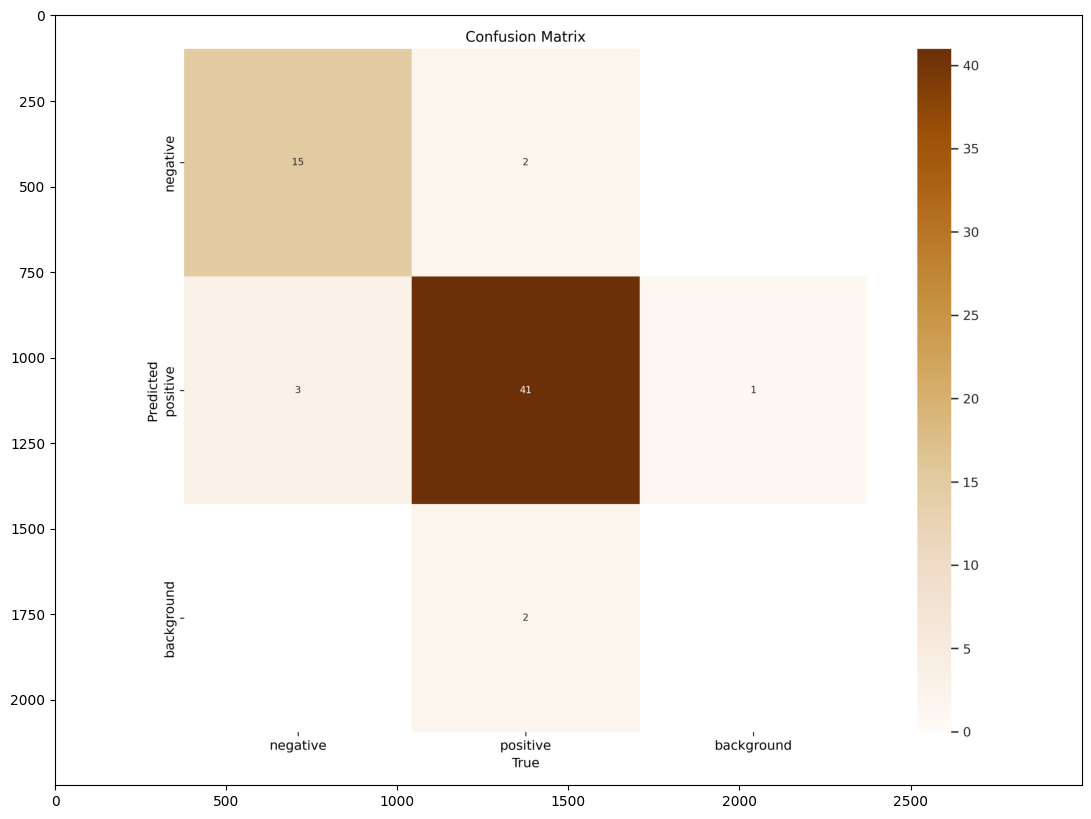

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

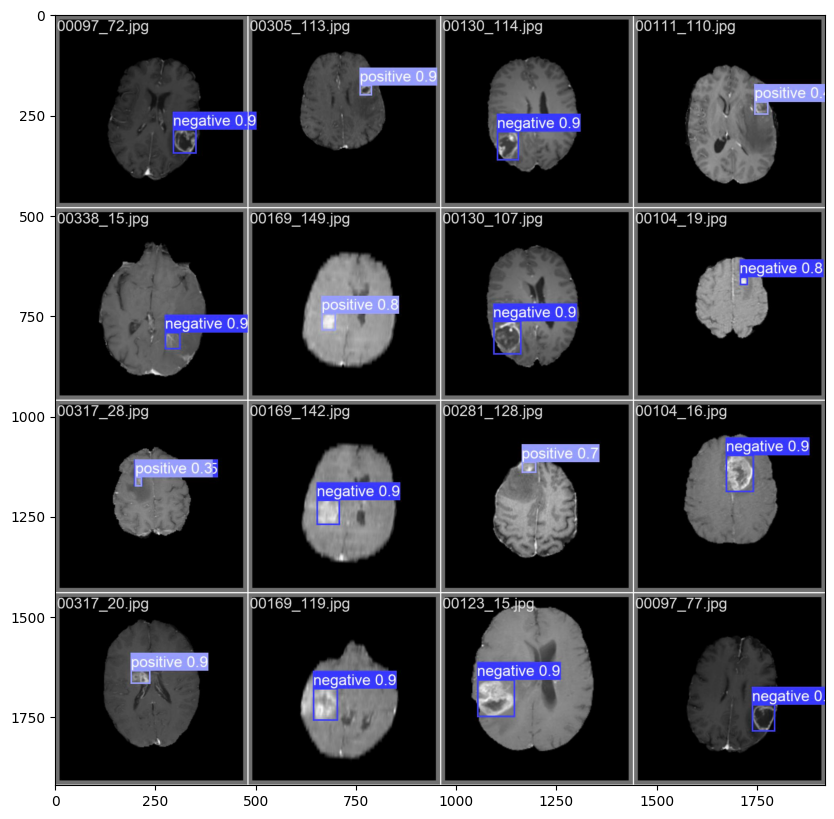

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

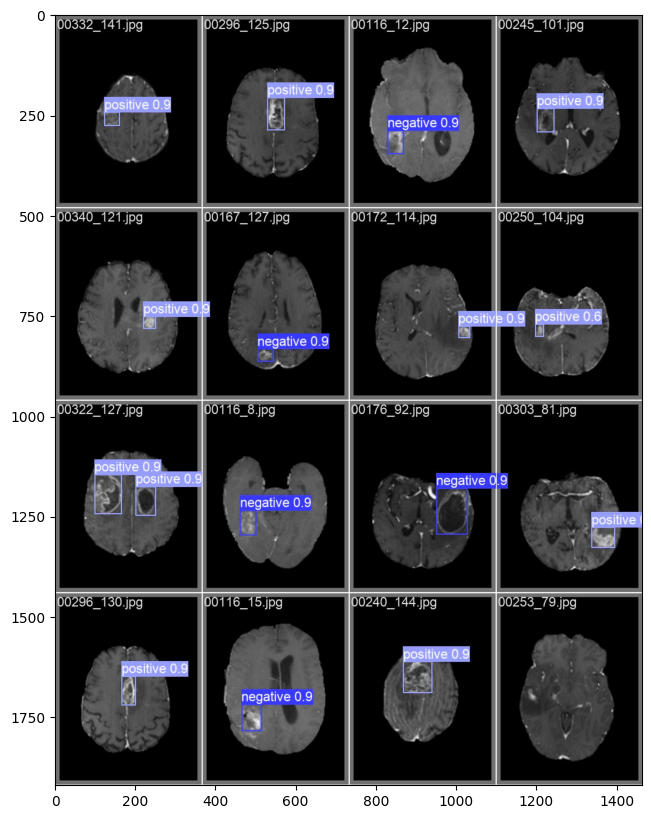

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [ ]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 2 negatives, 16.3ms
image 2/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 2 negatives, 16.3ms
image 3/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 1 negative, 16.3ms
image 4/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 1 negative, 16.3ms
image 5/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 14.8ms
image 6/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 14.7ms
image 7/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 (no detections), 14.7ms
image 8/75 /kaggle/input/brain-tu

In [ ]:
#print(predictions[4])

In [ ]:
predictions_save_dir = '/kaggle/working/' + predictions[0].save_dir + '/labels'

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['0', '0.603624', '0.446546', '0.107791', '0.116379', '0.928003\n']
['0', '0.605047', '0.444249', '0.109155', '0.113850']


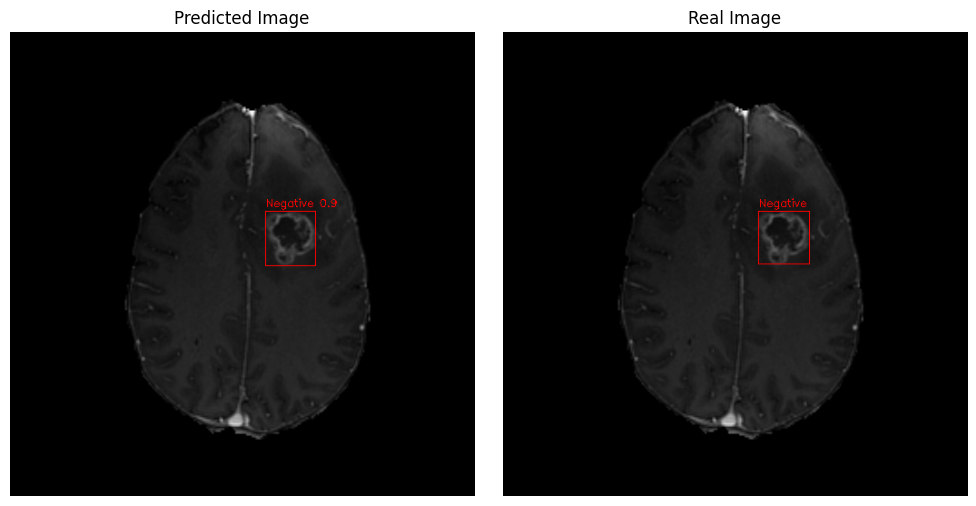

In [ ]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [ ]:
metrics = trained_model.val(data="test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.205 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
val: Scanning /kaggle/working/dataset/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 1213.90it/s]
val: New cache created: /kaggle/working/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                   all         75         81      0.697      0.938      0.864      0.664
              negative         75         81      0.697      0.938      0.864      0.664
Speed: 3.5ms preprocess, 10.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val9


In [ ]:
test_save_dir = '/kaggle/working/' + str(metrics.save_dir)

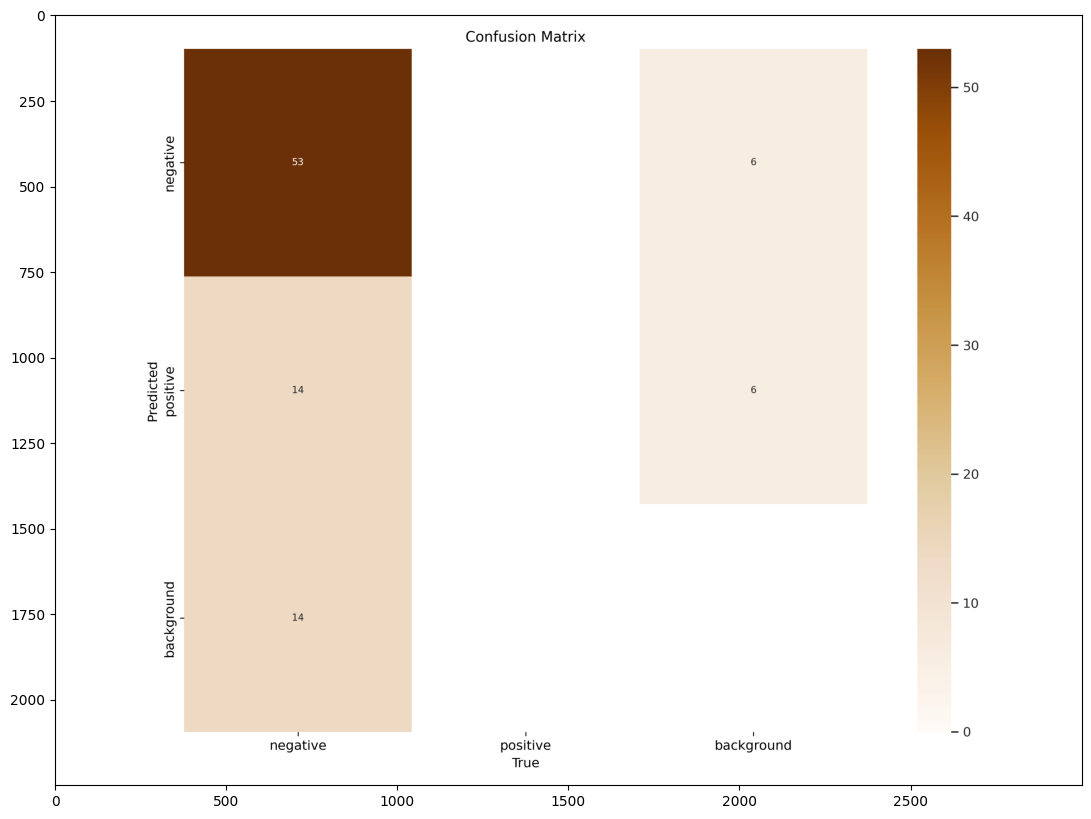

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

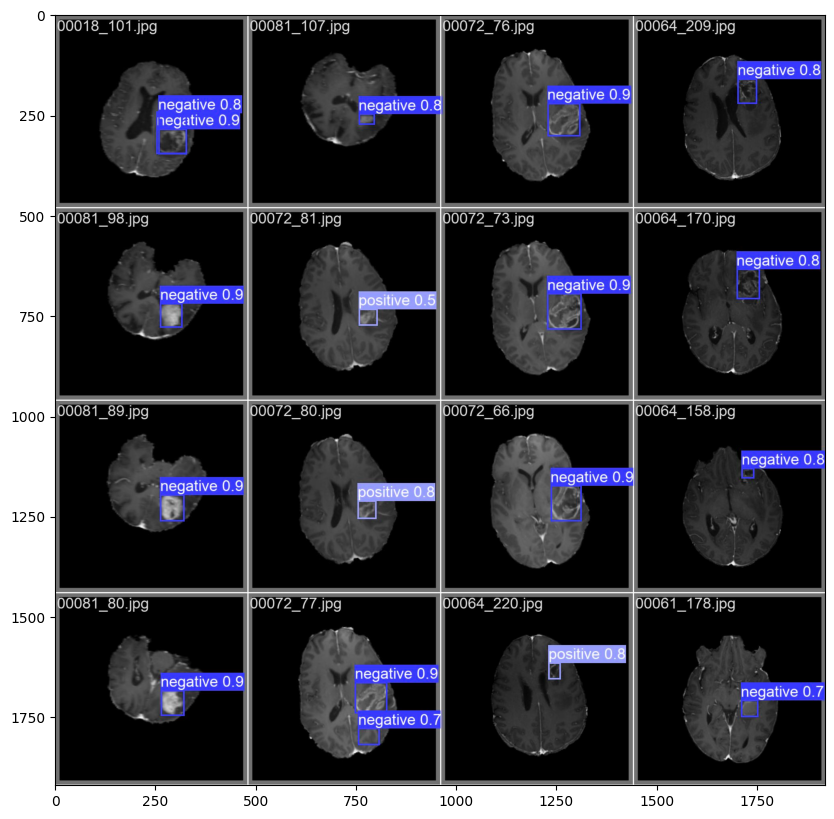

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

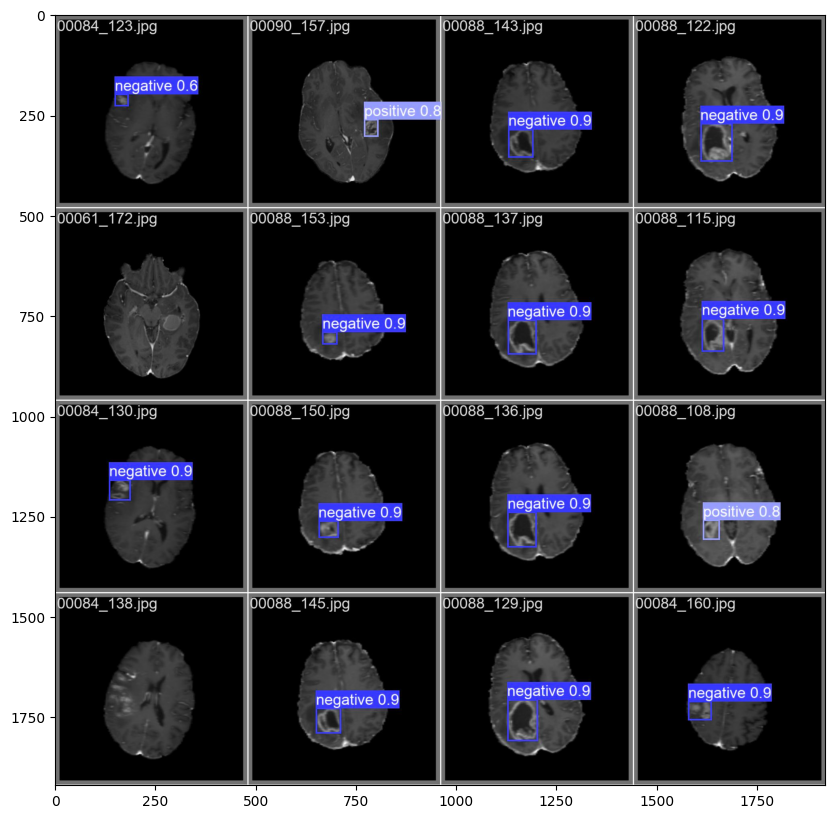

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()